In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
plt.style.use("fivethirtyeight")

In [77]:
training_table = pd.read_csv("./data/occupancy_data/datatraining.txt")

In [78]:
# training_table["year"] = training_table["date"].str[:4].astype(int) # only 2015
# training_table["month"] = training_table["date"].str[5:7].astype(int) # only February
training_table["day"] = training_table["date"].str[8:10].astype(int)
training_table["hour"] = training_table["date"].str[11:13].astype(int)

In [80]:
training_table = training_table.drop("date", axis=1)

In [91]:
training_table.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
1,23.18,27.2720,426.0,721.25,0.004793,1,4,17
2,23.15,27.2675,429.5,714.00,0.004783,1,4,17
3,23.15,27.2450,426.0,713.50,0.004779,1,4,17
4,23.15,27.2000,426.0,708.25,0.004772,1,4,17
5,23.10,27.2000,426.0,704.50,0.004757,1,4,17


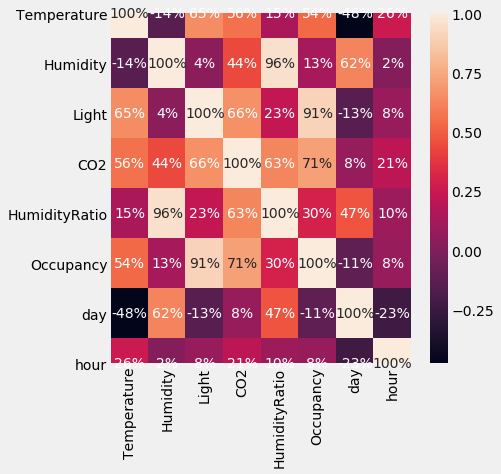

In [82]:
plt.figure(figsize=(6, 6))
sns.heatmap(training_table.corr(), annot=True, fmt=".0%")

In [127]:
SEQ_LEN = 50
NUM_FEAT = 7
DROP = 0.3

In [136]:
X_train = training_table.drop("Occupancy", axis=1).values
Y_train = training_table["Occupancy"].values
training_sequence = [(X_train[i:i+SEQ_LEN, :], Y_train[i+SEQ_LEN]) for i in range(0, len(X_train) - SEQ_LEN)]
N = len(Y_train)

In [122]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from rnn import StochasticLSTM
from utils import DropoutBCELoss

In [119]:
dataloader = torch.utils.data.DataLoader(training_sequence, batch_size=1, shuffle=True, num_workers=2)

In [123]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(NUM_FEAT, 50, dropout_rate=DROP)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = torch.relu(self.fc1(result))
        result = torch.sigmoid(self.fc2(result))
        return result

In [133]:
net = Net().double()

In [134]:
criterion = DropoutBCELoss(1, 1, DROP)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [139]:
for epoch in range(1):
    running_loss = 0.0
    
    for i, (x, y) in enumerate(dataloader):
        x = x.transpose(1, 0)
        out = net(x)
        loss = criterion(out, y.double(), net.rnn.named_parameters(), N)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 300 == 299:
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0
        
print("Finish training")

[1,   300] loss: 0.565351
[1,   600] loss: 0.411088
[1,   900] loss: 0.316304
[1,  1200] loss: 0.258982
[1,  1500] loss: 0.241826
[1,  1800] loss: 0.220397
[1,  2100] loss: 0.265565
[1,  2400] loss: 0.220272
[1,  2700] loss: 0.252823
[1,  3000] loss: 0.277060
[1,  3300] loss: 0.267918
[1,  3600] loss: 0.193880
[1,  3900] loss: 0.295439
[1,  4200] loss: 0.290935
[1,  4500] loss: 0.203591
[1,  4800] loss: 0.332665
[1,  5100] loss: 0.331620
[1,  5400] loss: 0.277884
[1,  5700] loss: 0.227666
[1,  6000] loss: 0.211179
[1,  6300] loss: 0.270516
[1,  6600] loss: 0.216887
[1,  6900] loss: 0.248674
[1,  7200] loss: 0.228037
[1,  7500] loss: 0.217195
[1,  7800] loss: 0.157516
Finish training


## Test

In [ ]:
testing_table = pd.read_csv("./data/occupancy_data/datatest2.txt")
testing_table["day"] = testing_table["date"].str[8:10].astype(int)
testing_table["hour"] = testing_table["date"].str[11:13].astype(int)
testing_table = testing_table.drop("date", axis=1)

In [ ]:
X_test = testing_table.drop("Occupancy", axis=1).values
X_test = np.array([X_test[i:i+SEQ_LEN, :] for i in range(0, len(X_test) - SEQ_LEN)])
X_test = X_test.swapaxes(1, 0)
Y_test = testing_table["Occupancy"].values[SEQ_LEN:]

In [168]:
X_test = torch.tensor(X_test)

In [185]:
with torch.no_grad():
    outputs = net(X_test).flatten().data.numpy()

In [187]:
from sklearn.metrics import roc_auc_score

In [189]:
roc_auc_score(Y_test, outputs)

0.9781943129358736